# Quantum Nonsense

## Introduction

Free recall is an important form of exploration: given a set of concepts stored in an organism's memory, how can the organism efficiently search its memory space to recall as many of the concepts as possible?

Naim *et al.* argue that free recall can be described by a deterministic search on a random graph, where the nodes in the graph represent the pool of concepts which could be recalled. Each edge between two nodes is assigned a random weight, which represents the similarity between those concepts. This model assumes that the "similarity" between two concepts is a fixed value which does not depend on context.  That is, the similarity from concept X to concept Y, denoted $Sim(X,Y)$, is the same regardless of the path taken to arrive at concept X.

Human behavioral experiments, however, have demonstrated the existence of context effects for similarity judgements: it could be true that $Sim(X,Y) > Sim(X,Z)$ in one context while $Sim(X,Y) < Sim(X,Z)$ in another context. In 2015, Yearsley *et al.* proposed an explanation for this phenominon using a model of similarity judgements based on quantum probability theory. In this theory, the space of possible thoughts is represented by a Hilbert space *H*. Within this space, there are many lower-dimensional subspaces, each of which represents a single concept and which is defined as the space of thoughts consistent with that concept.

In the quantum model, the similarity $Sim(X,Y)$ is defined as $| P_y P_x |𝜓⟩ |^2$, where $P_y$ and $P_x$ are the projection matrices defining the two conceptual subspaces, and $|𝜓⟩$ represents the mental state (the superposition of thoughts) before the comparison was made. This model demonstrations context effects because the similarity measurement varies depending on the location of $P_x |𝜓⟩$ within the overall X subspace. This model also contains order effects since in general $P_y P_x \ne P_x P_y$.

In this project, I apply the notion of quantum similarity to the free recall problem. I construct a model of quantum free recall in which the classical notion of "graph node" is replaced by "subspace within a higher-dimensional space" and the notion of "graph transition" is replaced by "projection between subspaces". This quantum free recall model thus contains a path-dependency effect which is not present in Naim *et al.*'s graph model. This path-dependency effect might allow the quantum model to recall a larger fraction of possible concepts. Perhaps the probability distribution of recalled items will differ in a way that makes the quantum and classical models distinguishable even if the number of recalled items is the same.


## Agents / Environments

Free recall differs from many other forms of exploration in that the "environment" and "agent" are very tightly linked.

### Classical Model

The classical environment is a random graph of concepts which can be transversed. There is only one parameter *N*, the number of nodes, which is the number of concepts which could be recalled. The weights of the graph edges, representing similarities, are defined by generating a *random symmetric matrix*.

The classical agent searches the random graph using a deterministic procedure: from the current node, follow the edge with the highest similarity, ignoring the edge that was transversed immediately previously. The number of nodes visited (before the agent gets stuck in a loop) is a random value based on the weights of the graph.


### Quantum Model

The quantum environment has two components. The first is a high dimensional Hilbert space, which is defined by a single number *HighDim* indicating the dimensionality of the space.  The second component is the set of *N* conceptual subspaces, which are parameterized by another number *LowDim*. Each conceptual subspace is defined using *LowDim* unique random vectors, which span the space of thoughts that correspond to that concept. The vectors for each subspace are used to construct a projection matrix for that subspace. The high-dimensional space of thoughts can be transversed using a sequence of these projections.

The quantum agent, for this project, still uses a deterministic procedure, similar to the classical agent.

1. The state vector $|𝜓⟩$ is randomly generated at the start
2. The state vector gets updated according to $|𝜓⟩ := \frac{P_x |𝜓⟩}{|P_x |𝜓⟩|} $ where $P_x$ is the projection matix for the initial concept.
3. The similarities from the current concept to all other concepts are calculated according to $| P_y |𝜓⟩ |^2$. Note that the $P_x$ is not present because state has already been projected to subspace X.
4. The next concept is selected based on which one had the highest similarity.
5. The state vector now becomes $|𝜓⟩ := \frac{P_y |𝜓⟩}{|P_y |𝜓⟩|} $ where $P_y$ is the projection matix for the new concept.
6. The steps are repeated, with the agent always visiting the concept with the highest similarity to the current state. Additionally, the "no reversing direction" rule is carried over from the classical model, so that the agent never projects back to the concept it was just at immediately previously.


## Goals

The primary objective is to explore the effects of two important parameters on performance: the dimensionality *HighDim* of the high-dimensional Hilbert space of all thoughts, and the dimensionality *LowDim* of the conceptual subspaces.

The secondary objective is to explore the statistical properties of the quantum model and compare these properties to the classical model.

## Sections
There are _4_ sections to this project.

- Section 1: Reproduction of Classical Results
 - I verify the classical model works as advertised
- Section 2: The effect of Hilbert space dimensionality when the individual conceptual subspaces are small
 - I look at how performance changes when the concepts are small dimensional spaces in a really high dimensional space
- Section 3: The effect of conceptual subspace dimensionality as the Hilbert dimension approaches infinity
 - I look for scaling laws to that dictate how performance is affected by the ratio the subspace dimensionality to overall dimensionality
- Section 4: Comparing Statistical Properties
 - I see if there's a way to distinguish classical and quantum models that recall similar numbers of items.

## Metric

The primary metric of interest is recall rate, which is the number of recalled items out of the set of N possible items.

Later, some additional metrics are explored:

- The cumulative distribution of the number of recalled items
- The probability of a new recall at each time step in the simulation
- The cumulative number of recalls over the course of the simulation


## The TED talk moment

The core question of this project is: can quantum cognition help memory, and can we detect when quantum probabilities are being used to aid in recall?

Quantum cognition represents a dramatic departure from traditional cognitive models, and its application to various areas of cognition is still relatively unexplored. This project serves to build a bridge between the area of quantum cognition and the area of free recall.

If quantum cognition is a viable tool for improving recall rates, and the statistical properties of the quantum model are distinguishable from classical models, then this project would establish specific predictions which could then be tested in humans. The largest issue in the field of quantum cognition is the difficulty in forming testable hypotheses (rather than just fitting existing data). So the discovery of a useful prediction could serve as an important basis for future research in memory and recall.

## Install and import needed modules

### Import modules
Import what _you_ need

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.colors as colors
import matplotlib.cm as cm
from copy import copy

### Config notebook

In [2]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True

plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

## Shared code

### Classical Model

In [3]:
def sampleClassical(size,lowdim=None,highdim=None):
    assert lowdim is None and highdim is None
    mat = np.zeros((size,size))
    vals = int(size * (size-1) / 2)
    vals = np.random.choice(vals, size=vals, replace=False)
    counter = 0
    for i in range(size):
        mat[i][i] = 0
        for j in range(i):
            mat[i][j] = vals[counter] + 1
            mat[j][i] = vals[counter] + 1
            counter += 1

    prevstate = 0
    state = 0
    visited = {0}
    
    hist = np.zeros(1000)
    hist[0] = 1
    
    for i in range(1,len(hist)):
        newstate = np.argmax(mat[state])
        if newstate == prevstate:
            newstate = np.argsort(mat[state])[-2]
        prevstate = state
        state = newstate
        if state not in visited:
            hist[i] = 1
            visited.add(state)
    return hist

### Quantum Model

In [4]:
def l2(vect):
    # the l2 norm of a vector
    return np.linalg.norm(vect)

In [5]:
def unit(vect):
    # turn a vector into a unit vector
    return vect/l2(vect)

In [6]:
def makeProjector(vectorlist):
    A = np.array(vectorlist).T
    Pa = A.dot(np.linalg.inv(A.conj().T.dot(A))).dot(A.conj().T)
    return Pa

In [7]:
def genRandUnitVectorComplex(dim):
    # produces a complex unit vector with random orientation
    vect = np.random.normal(size=dim) + 1j * np.random.normal(size=dim)
    return unit(vect)

In [8]:
def randSubspaceComplex(lowdim,highdim):
    # produce a random projection matrix from a higher to lower dimensional space
    return makeProjector([genRandUnitVectorComplex(highdim) for i in range(lowdim)])

In [9]:
def sampleQuantum(size,lowdim,highdim):
    assert highdim > lowdim
    
    projectors = [randSubspaceComplex(lowdim,highdim) for i in range(size)]
    prevstate = 0
    state = 0
    visited = {0}
    statevector = unit(projectors[0].dot(genRandUnitVectorComplex(highdim)))
    
    hist = np.zeros(1000)
    hist[0] = 1
    
    for i in range(1,len(hist)):
        ordering = np.argsort([l2(projector.dot(statevector)) for projector in projectors]) # relative distances
        newstate = ordering[-2]
        if newstate == prevstate:
            newstate = ordering[-3]
        prevstate = state
        statevector = unit(projectors[newstate].dot(statevector))
        state = newstate
        if state not in visited:
            hist[i] = 1
            visited.add(state)
    return hist

### Data Management

In [52]:
models = {
    'classical':sampleClassical,
    'quantum':sampleQuantum,
}
cache = {}
try:
    cache = pickle.load(open("cache.p","rb"))
except:
    pass

In [24]:
def cachefetch(model,minsamplesize,sizes,lowdims=None,highdims=None):
    sizes = np.array(sizes).flatten()
    lowdims = np.array(lowdims).flatten()
    highdims = np.array(highdims).flatten()
    
    for size in sizes:
        for lowdim in lowdims:
            for highdim in highdims:
                if model not in cache:
                    cache[model] = {}
                if size not in cache[model]:
                    cache[model][size] = {}
                if lowdim not in cache[model][size]:
                    cache[model][size][lowdim] = {}
                if highdim not in cache[model][size][lowdim]:
                    cache[model][size][lowdim][highdim] = []  
    
    itercount = 0
    
    for size in sizes:
        for lowdim in lowdims:
            for highdim in highdims:
                if highdim is None or highdim > lowdim:
                    if len(cache[model][size][lowdim][highdim]) < minsamplesize:
                        itercount = max(itercount, minsamplesize - len(cache[model][size][lowdim][highdim]))
    
    if itercount > 0:
        for sample in tqdm(range(itercount)):
            for size in sizes:
                for lowdim in lowdims:
                    for highdim in highdims:
                        if highdim is None or highdim > lowdim:
                            if len(cache[model][size][lowdim][highdim]) < minsamplesize:
                                #pass
                                cache[model][size][lowdim][highdim].append(models[model](size,lowdim,highdim))
        pickle.dump(cache,open("cache.p","wb"))
                            
    sizeoutput = []
    lowdimoutput = []
    highdimoutput = []
    dataoutput = []
    for size in sizes:
        for lowdim in lowdims:
            for highdim in highdims:
                if highdim is None or highdim > lowdim:
                    data = cache[model][size][lowdim][highdim]
                    dataoutput.extend(data)
                    sizeoutput.extend([size]*len(data))
                    lowdimoutput.extend([lowdim]*len(data))
                    highdimoutput.extend([highdim]*len(data))
                    
    return ( # sizes,lowdims,highdims,history,counts
        np.array(sizeoutput),
        np.array(lowdimoutput),
        np.array(highdimoutput),
        np.array(dataoutput),
        np.array(dataoutput).sum(axis=1),
    )

## Section 1: Reproduction of Classical Results

In this section, we characterise the performance of the classical model across a few values for N (the size of the graph). Our two main objectives are:

1. Show that the average # of recalled items does scale according to the square root of N.
2. Get a qualitative feel for the shape of the recall histograms, and decide which graph sizes would serve as the best basis for comparison for the quantum models.

I expect the results to match Naim et al. very closely.

First we run 10000 sims for size = 8,16,32,64

In [106]:
sizes,lowdims,highdims,history,counts = cachefetch('classical',10000,[8,16,32,64])

In [107]:
classicalmean = {}
for N in [8,16,32,64]:
    classicalmean[N] = counts[np.where(sizes==N)].mean()
classicalmean

{8: 5.5846, 16: 8.1711, 32: 11.8233, 64: 16.895}

Figure 1: The # recalled for various graph sizes

Text(0.5, 1.0, 'Effect of Size on Concepts Recalled')

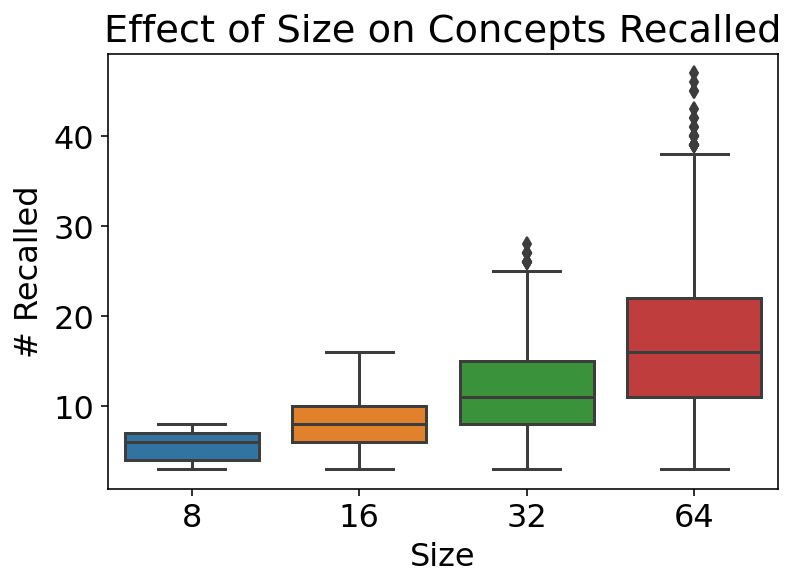

In [108]:
ax = sns.boxplot(x=sizes,y=counts)
ax.set_xlabel("Size")
ax.set_ylabel("# Recalled")
ax.set_title("Effect of Size on Concepts Recalled")

Figure 2: The counts of recalled concepts exhibits the square-root scaling demonstrated in Naim et al.

Text(0.5, 1.0, 'Effect of Size on Concepts Recalled')

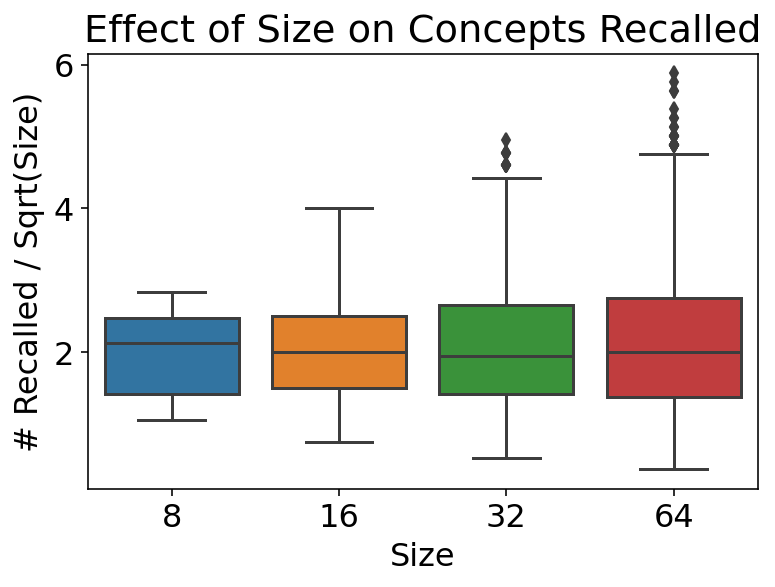

In [109]:
ax = sns.boxplot(x=sizes,y=counts/np.sqrt(sizes))
ax.set_xlabel("Size")
ax.set_ylabel("# Recalled / Sqrt(Size)")
ax.set_title("Effect of Size on Concepts Recalled")

Based on the above plot, we can conclude that the square-root scaling does hold, as expected.

Figure 3: Histogram plots showing the variation in the number of recalled concepts.

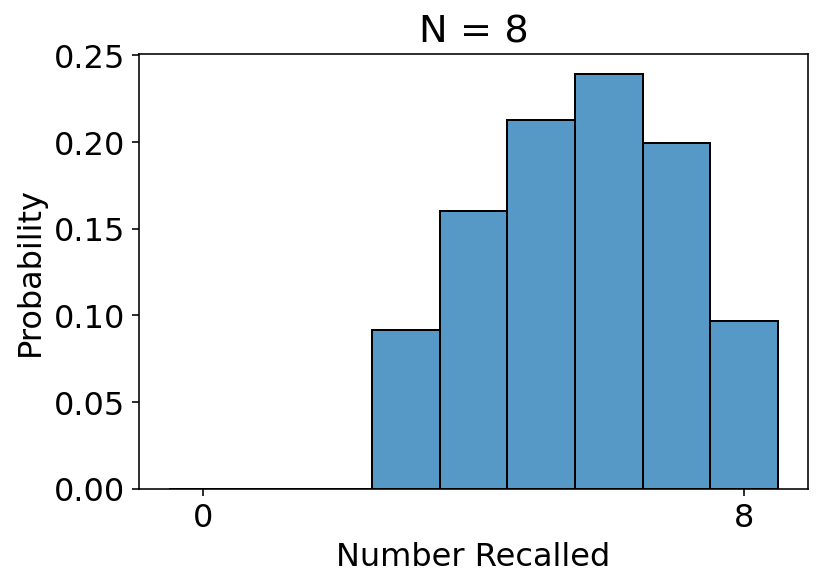

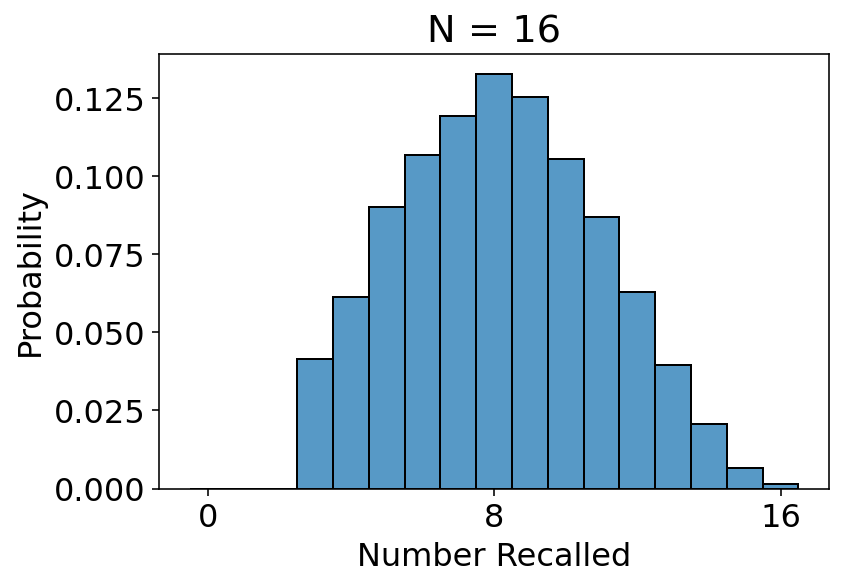

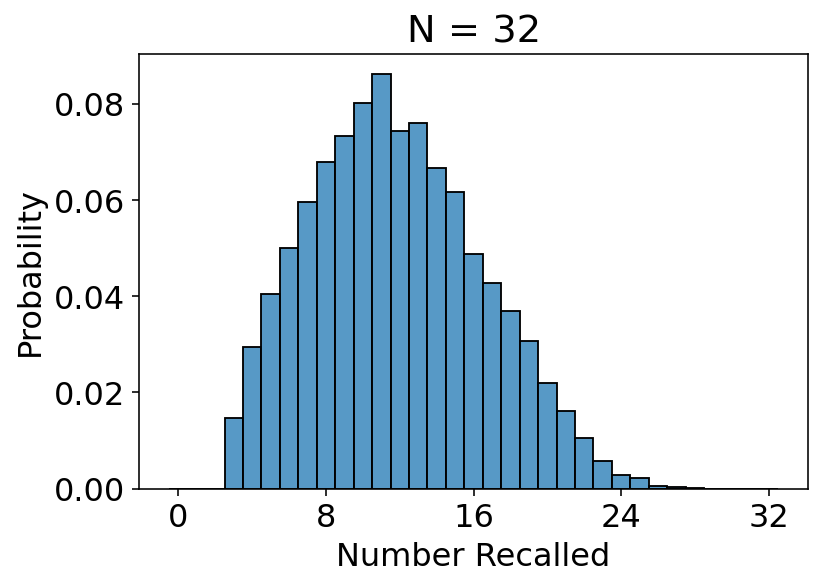

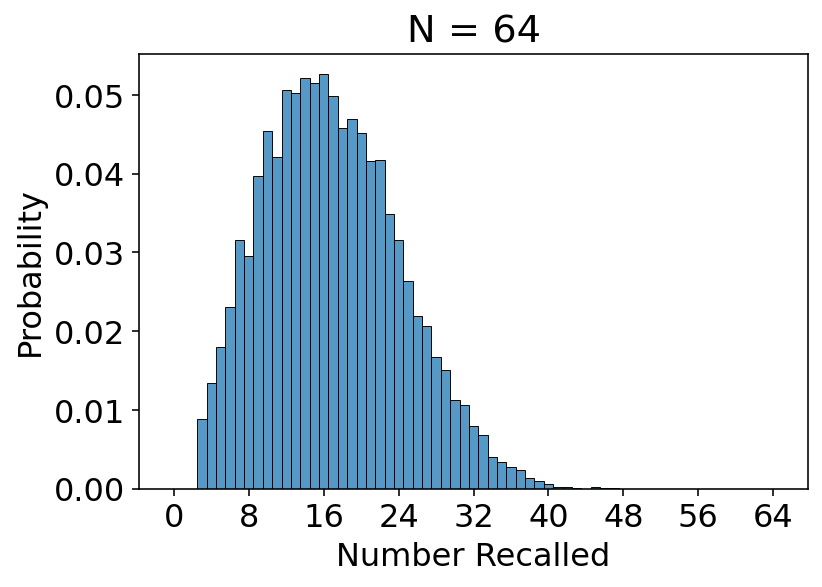

In [110]:
for N in [8,16,32,64]:
    ax = sns.histplot(data=counts[np.where(sizes==N)],bins=np.arange(N+2)-0.5,stat='probability');
    ax.set_xticks(np.arange(N+1,step=8));
    ax.set_title('N = ' + str(N));
    ax.set_xlabel('Number Recalled');
    plt.show()

As the number of concepts increases, the mean of the graph shifts to the left (relative to its scale) and the distribution becomes more right-skewed.

### Conclusions:

The classical results match expectations.

For the purposes of the quantum model, I settled on size=16 and size=32 as the main two sizes to explore, as these graphs exhibit the fundamental shape. Size=64 is too slow for my quantum simulations and size=8 is too small to produce an interesting distribution.

## Section 2: The effect of Hilbert space dimensionality when the individual conceptual subspaces are small

In this section, the recall rates of the quantum model are explored when each concept is represented by a small-dimensional space, ranging from 1 to 4 dimentions.

I hypothesize that the larger the dimensionality of the subspaces, the stronger the deviation from the classical model, as the dimensionality of the subspace roughly corresponds to the amount of contexual effects which are possible.

We first consider a sweep across parameter space in the following manner:

- The number N of concepts is fixed at 16
- The value of LowDim ranges from 1 to 4
- The dimensionality HighDim of the higher-dimensioal Hilbert space range from 2 to 64

We run 100 trials at each combination of values

In [25]:
sizes,lowdims,highdims,history,counts = cachefetch('quantum',100,16,[1,2,3,4],np.arange(2,64+1))

Figure 4: Here we visualize the relationship between the subspace dimensionality, the overall dimensionality, and the number of recalled items.

(0.0, 16.0)

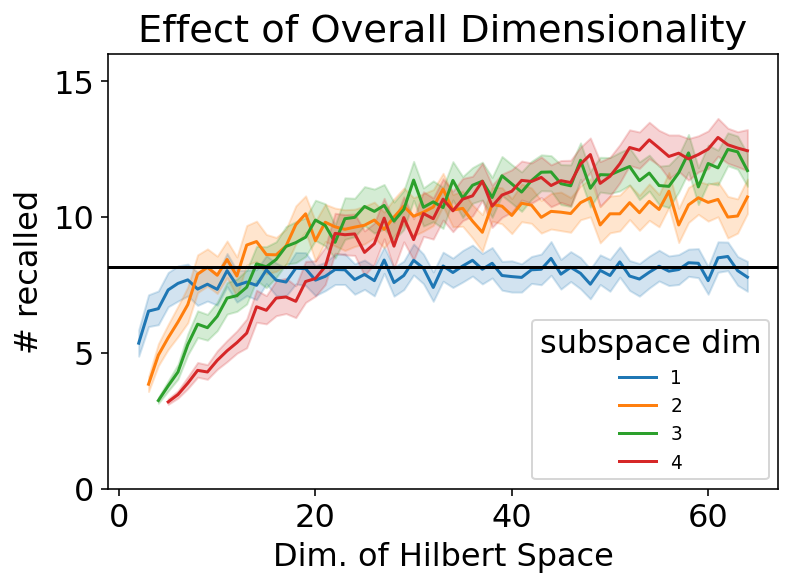

In [36]:
for lowdim in [1,2,3,4]:
    ax = sns.lineplot(x=highdims[np.where(lowdims==lowdim)], y=counts[np.where(lowdims==lowdim)])
ax.set_xlabel('Dim. of Hilbert Space')
ax.set_ylabel('# recalled')
ax.set_title('Effect of Overall Dimensionality')
ax.axhline(classicalmean[16],color='k')
ax.legend(['1','2','3','4'], title="subspace dim", fontsize='xx-small')
ax.set_ylim((0,16))

From the graph, there's a few key observations:

- Higher-dimensional subspaces give rise to higher recall rates
- Subspaces of with higher dimensionality give worse performance at the start but improve as the overall dimensionality increases
- The recall rate, given a fixed dimensionality for concepts, seems to plateau as the overall dimensionality increases
- The recall rate for subspace dimensionality of 1 converges to the classical value.

Next, I repeat the parameter sweep, but increase the number of concepts from 16 to 32.

In [37]:
sizes,lowdims,highdims,history,counts = cachefetch('quantum',100,32,[1,2,3,4],np.arange(2,64+1))

Figure 5: Visualizing the asymptotic nature of recall performance with a higher number of concepts.

(0.0, 32.0)

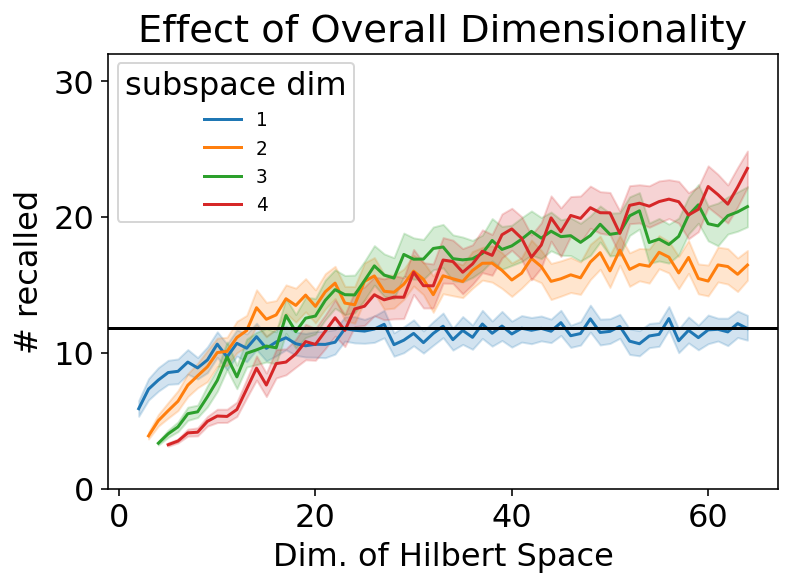

In [39]:
for lowdim in [1,2,3,4]:
    ax = sns.lineplot(x=highdims[np.where(lowdims==lowdim)], y=counts[np.where(lowdims==lowdim)])
ax.set_xlabel('Dim. of Hilbert Space')
ax.set_ylabel('# recalled')
ax.set_title('Effect of Overall Dimensionality')
ax.axhline(classicalmean[32],color='k')
ax.legend(['1','2','3','4'], title="subspace dim", fontsize='xx-small')
ax.set_ylim((0,32))

It appears that the behavior with 32 concepts is similar to the behavior with 16 concepts. A slightly larger Hilbert space seems needed to produce comparable performance.

### Conlusions:

When each concept has a smalll number of dimensions, the performance reaches an asymptote as the Hilbert dimension increases.

When the model has 1D subspaces, it barely really a quantum model at all, as the only quantum property is the phase which is extremely hard to measure in practice. The perforance seems to match the classical model.


## Section 3: The effect of conceptual subspace dimensionality as the Hilbert dimension approaches infinity

In this section I will more closely examine the performance as a function of the ratio between the subspace dimensionality (LowDim) and the overall Hilbert space dimensionality (HighDim).

I hypothesize that higher-dimensionality Hilbert caps have a higher cap on performance, but that a larger subspace dimension is required to acheive that performance.

I would also like to determine if some kind of scaling law exists: whether there's a specific ratio of dimensionalities that works best.

First I run a parameter sweep in the following manner:

- N=16
- The Hilbert dimensionality is increased in powers of two from 2^1 to 2^6
- The conceptual dimensioanlity is varied across the full range of possible values

In [40]:
sizes,lowdims,highdims,history,counts = cachefetch('quantum',50,16,np.arange(1,64),[2,4,8,16,32,64])

Figure 6: This lineplot shows how performance changes when the Hilbert dimensionality is fixed while the subspace dimensionality changes.

(0.0, 16.0)

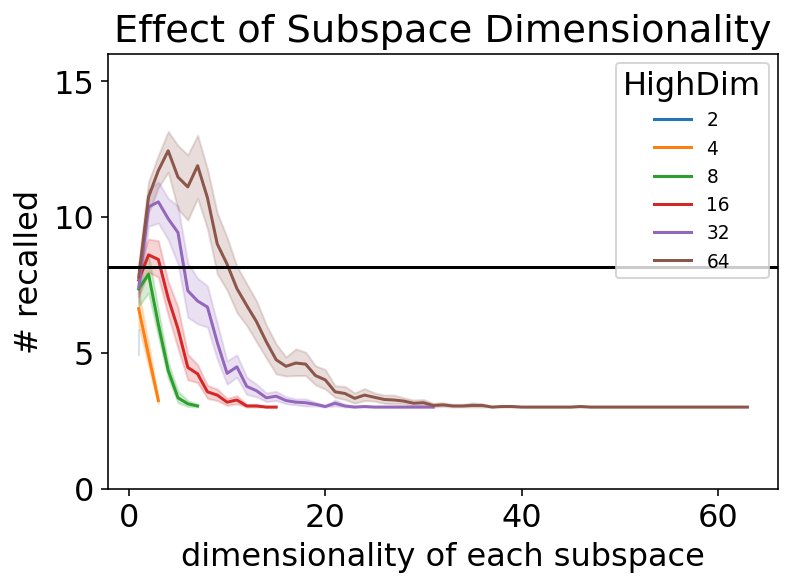

In [50]:
for highdim in [2,4,8,16,32,64]:
    ax = sns.lineplot(x=lowdims[np.where(highdims==highdim)],y=counts[np.where(highdims==highdim)])
    
ax.legend(['2','4','8','16','32','64'], title="HighDim", fontsize='xx-small')
ax.set_xlabel('dimensionality of each subspace')
ax.set_ylabel('# recalled')
ax.axhline(classicalmean[16],color='k')
ax.set_title('Effect of Subspace Dimensionality')
ax.set_ylim((0,16))

From this graph, we can draw a few observatons:

- Increasing the Hilbert dimensionality strictly improves performance
- Each value for Hilbert dimensionality has an optimal value for subspace dimensionality.
- (For larger values) The performance basically starts at the classical baseline, rises above it, but then tanks to extremely low performance if the subspace dimensionality becomes too large.

Next, to see if there's a scaling law of the form "LowDim is proportial to HighDim ^ power" I scale the X values from simply being the value of LowDim to be ln(LowDim)/ln(HighDim)

Figure 7: The performance when the subspace dimensionality is expressed as a fractional power of the overall dimensionality.

(0.0, 16.0)

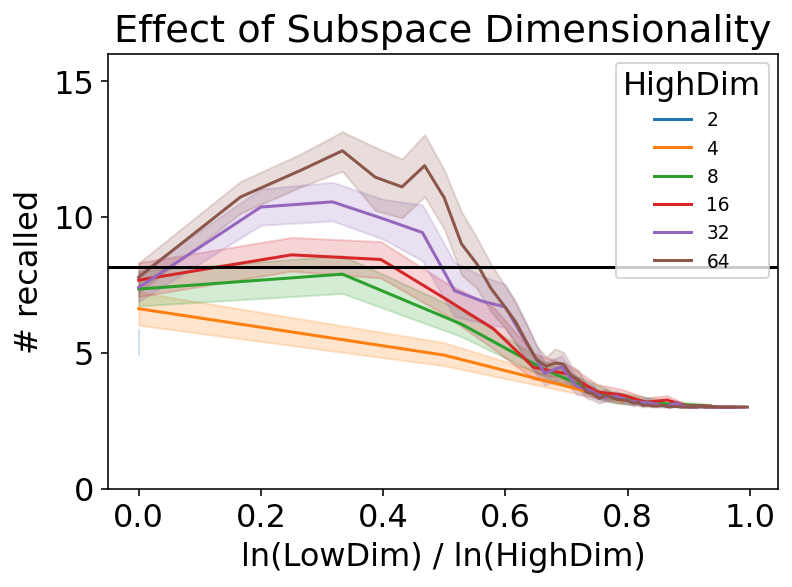

In [51]:
for highdim in [2,4,8,16,32,64]:
    ax = sns.lineplot(x=np.log(lowdims[np.where(highdims==highdim)])/np.log(highdim),y=counts[np.where(highdims==highdim)])
    
ax.legend(['2','4','8','16','32','64'], title="HighDim", fontsize='xx-small')
ax.set_xlabel('ln(LowDim) / ln(HighDim)')
ax.set_ylabel('# recalled')
ax.axhline(classicalmean[16],color='k')
ax.set_title('Effect of Subspace Dimensionality')
ax.set_ylim((0,16))

From this graph, we see some evidence of a scaling law: as the overall dimension increases, the performance curve seems to rise upwards, and on the right part of the graph we see how the curves seem to approach a limiting curve.

To explore the possible existance of a power scaling law, a new parameter sweep was performed, in which the Hilbert space dimensionality was set to 1024 and the subspace dimensionality was selected to be [1,3,7,15,31,63,127].

In [53]:
sizes,lowdims,highdims,history,counts = cachefetch('quantum',10,16,2**np.arange(1,10-3+1)-1,2**10)


Figure 8: Power scaling for optimal subspace dimensionality given the overall dimensionality

(0.0, 16.0)

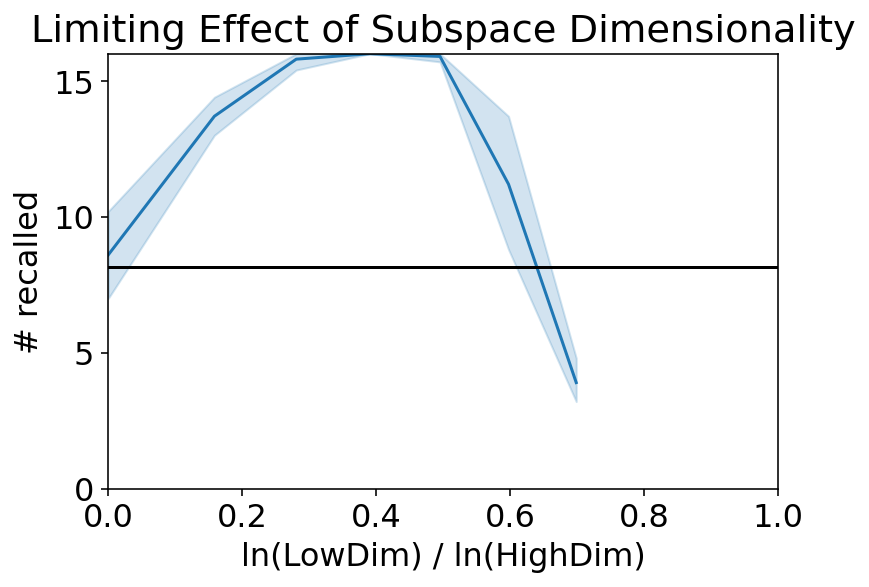

In [56]:
for highdim in [2**10]:
    ax = sns.lineplot(x=np.log(lowdims[np.where(highdims==highdim)])/np.log(highdim),y=counts[np.where(highdims==highdim)])
ax.set_xlabel('ln(LowDim) / ln(HighDim)')
ax.set_ylabel('# recalled')
ax.axhline(classicalmean[16],color='k')
ax.set_title('Limiting Effect of Subspace Dimensionality')
ax.set_xlim((0,1))
ax.set_ylim((0,16))

From this figure, we can see that optimal performance was achieved when the subspace dimensionality was approximately the overall dimensionality to the power of 0.4, and the performance dropped below baseline when the subspace dimensionality exceeded the overall dimensioanlity to the power of 0.6.

This suggests that there is some sort of power scaling function, and that a limiting curve exists as the dimensionality gets large.

Next I repeat this procedure with 32 concepts instead of 16.

In [58]:
sizes,lowdims,highdims,history,counts = cachefetch('quantum',50,32,np.arange(1,64),[2,4,8,16,32,64])

Figure 9: Performance curves with an increased number of concepts

(0.0, 32.0)

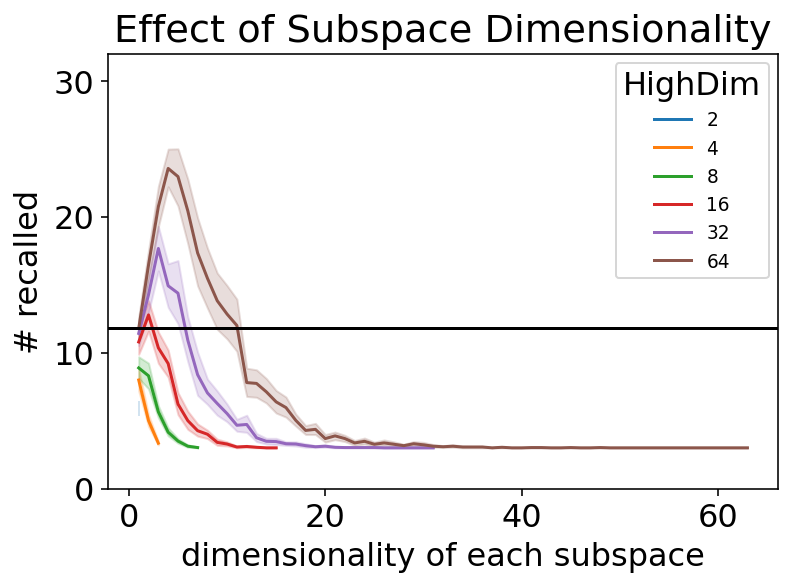

In [59]:
for highdim in [2,4,8,16,32,64]:
    ax = sns.lineplot(x=lowdims[np.where(highdims==highdim)],y=counts[np.where(highdims==highdim)])
    
ax.legend(['2','4','8','16','32','64'], title="HighDim", fontsize='xx-small')
ax.set_xlabel('dimensionality of each subspace')
ax.set_ylabel('# recalled')
ax.axhline(classicalmean[32],color='k')
ax.set_title('Effect of Subspace Dimensionality')
ax.set_ylim((0,32))

Figure 10: Logarithmic scaling applied the subspace dimensionality

(0.0, 32.0)

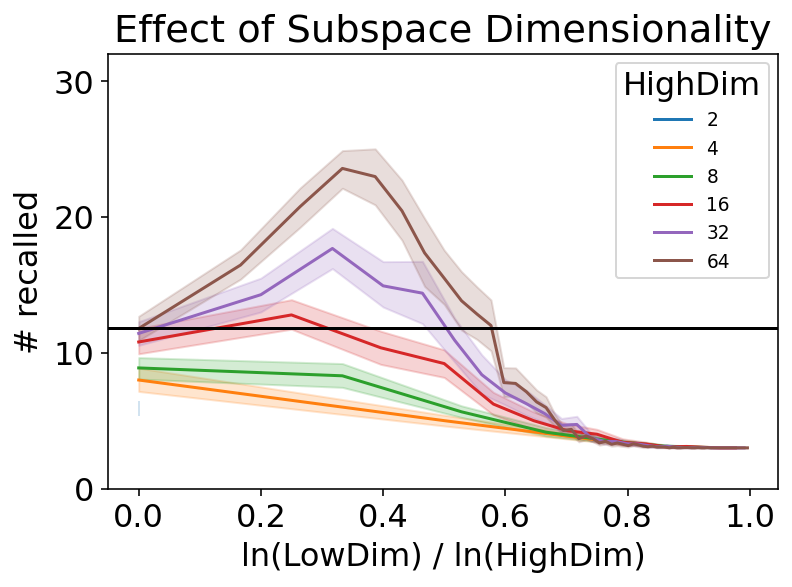

In [60]:
for highdim in [2,4,8,16,32,64]:
    ax = sns.lineplot(x=np.log(lowdims[np.where(highdims==highdim)])/np.log(highdim),y=counts[np.where(highdims==highdim)])
    
ax.legend(['2','4','8','16','32','64'], title="HighDim", fontsize='xx-small')
ax.set_xlabel('ln(LowDim) / ln(HighDim)')
ax.set_ylabel('# recalled')
ax.axhline(classicalmean[32],color='k')
ax.set_title('Effect of Subspace Dimensionality')
ax.set_ylim((0,32))

The curves for the 32-concept model appear very similar to the 16-concept model.

In [61]:
sizes,lowdims,highdims,history,counts = cachefetch('quantum',10,32,2**np.arange(1,10-3+1)-1,2**10)

Figure 11: Limiting curve with 32 concepts.

(0.0, 32.0)

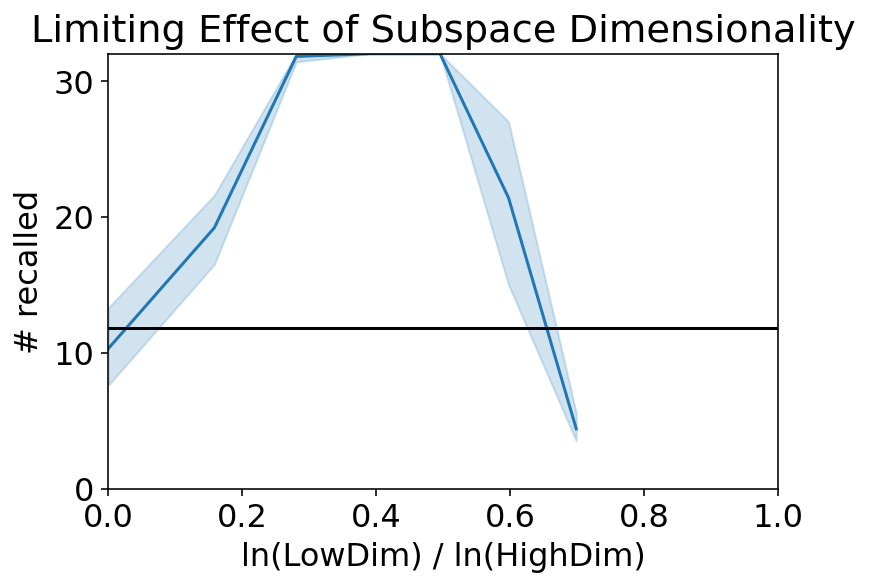

In [62]:
for highdim in [2**10]:
    ax = sns.lineplot(x=np.log(lowdims[np.where(highdims==highdim)])/np.log(highdim),y=counts[np.where(highdims==highdim)])
ax.set_xlabel('ln(LowDim) / ln(HighDim)')
ax.set_ylabel('# recalled')
ax.axhline(classicalmean[32],color='k')
ax.set_title('Limiting Effect of Subspace Dimensionality')
ax.set_xlim((0,1))
ax.set_ylim((0,32))

This limiting curve appears very similar in the 32-concept case at in the 16-concept case.

### Conclusions:

Increasing the overall dimension strictly improves performance, as shown in figures 6 and 9.

There appears to be a limiting curve, based on a power-scaling law. Performance is best when the subspace dimensionality scales proportionally to the overall dimensionality to the power of 0.4. Performance drops below baseline when that exponenent is 0.6.  The coefficients of the scaling law are unknown.

## Section 4: Comparing Statistical Properties

In this section I will perform a much more in-depth comparison of four models:

- The classical model with size 32
- The quantum model with 32 concepts, 1 dimension per concept, and a very high overall dimensionality
- The quantum model with 32 concepts, 2 dimensions per concept, and a very high overall dimensionality, which will have a higher recall rate
- The classical model with size 64, which will produce similar output numbers as the second quantum model with 2 subspace dims

I hypothesize that the 2D quantum model will have a large deviation in properties from the other models.

First I gather the data from the four models.

In [77]:
sizesC1,lowdimsC1,highdimsC1,historyC1,countsC1 = cachefetch('classical',10000,32)
sizesQ1,lowdimsQ1,highdimsQ1,historyQ1,countsQ1 = cachefetch('quantum',1000,32,1,128)
sizesQ2,lowdimsQ2,highdimsQ2,historyQ2,countsQ2 = cachefetch('quantum',1000,32,2,128)
sizesC2,lowdimsC2,highdimsC2,historyC2,countsC2 = cachefetch('classical',10000,64)

Next, I can best compare the shapes of their performanace distribution by plotting the cumulative distributions of each of the models. Changes in distribution shape will be noticeable on this graph.

Figure 12: Cumulative distributions of the recall rates of the four models under consideration.

(0.0, 32.0)

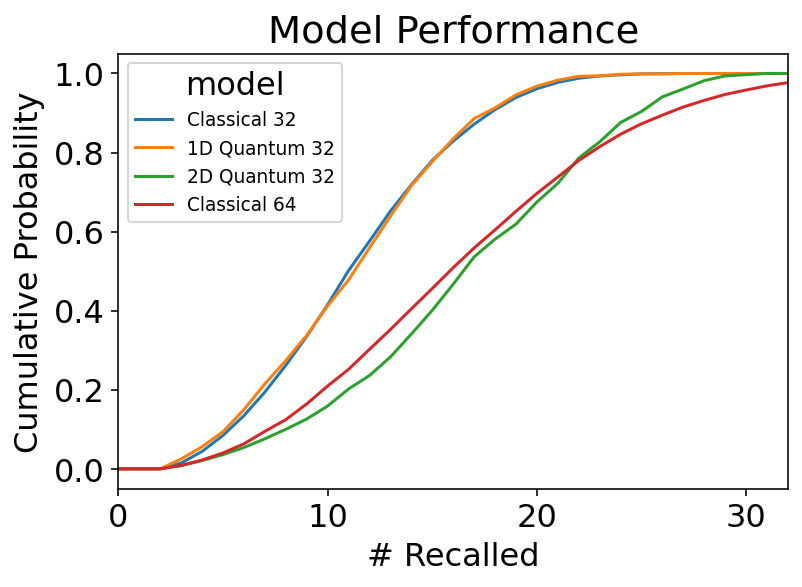

In [87]:
freqsC1,binsC1,_ = plt.hist(countsC1[np.where(sizesC1==32)],bins=np.arange(34));
freqsQ1,binsQ1,_ = plt.hist(countsQ1[np.where(sizesQ1==32)],bins=np.arange(34));
freqsQ2,binsQ2,_ = plt.hist(countsQ2[np.where(sizesQ2==32)],bins=np.arange(34));
freqsC2,binsC2,_ = plt.hist(countsC2[np.where(sizesC2==64)],bins=np.arange(66));
plt.clf();
plt.plot(np.cumsum(freqsC1)/sum(freqsC1))
plt.plot(np.cumsum(freqsQ1)/sum(freqsQ1))
plt.plot(np.cumsum(freqsQ2)/sum(freqsQ2))
plt.plot(np.cumsum(freqsC2)/sum(freqsC2))
plt.xlabel('# Recalled')
plt.ylabel('Cumulative Probability')
plt.legend(['Classical 32','1D Quantum 32', '2D Quantum 32', 'Classical 64'], title="model", fontsize='xx-small')
plt.title('Model Performance')
plt.xlim((0,32))

From this figure, we can see that, when quantum model has only 1 dimension in each conceptual subspace, the performance of the model is completely indentical to the classical model.

When the quantum model has 2D concepts, the performance significantly increases. The variance is slightly lower than the classical model containing double the number of concepts, based on the slightly steeper curve, but the deviation is quite minor.

This indicates that a classical agent capable of having a having size for its graph at the start (entering more concepts into memory in the first place) will perform very similarly to a quantum agent recalling from a smaller set of concepts.

Next, I investigate is anything meaningful can be seen in the step-by-step performance of the models.

Figure 13: Recalls over the simulation time course.

(0.0, 100.0)

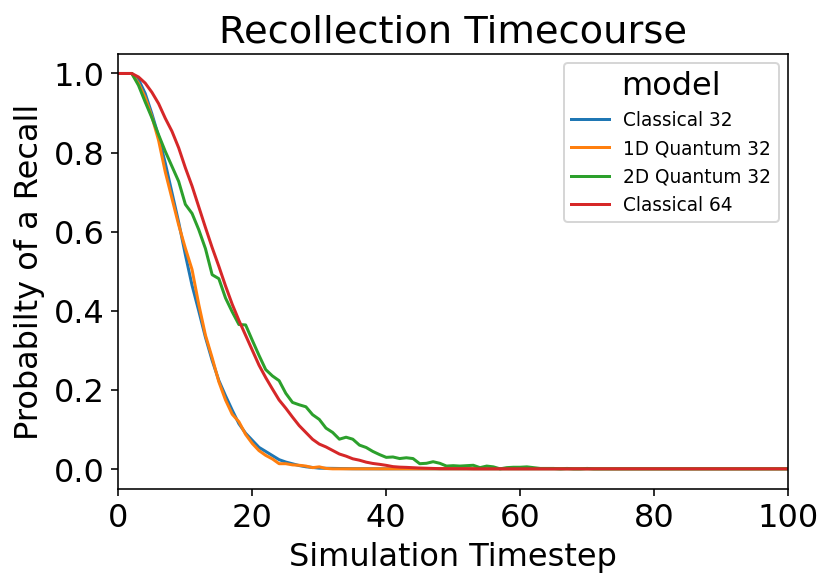

In [104]:
plt.plot(historyC1.mean(axis=0))
plt.plot(historyQ1.mean(axis=0))
plt.plot(historyQ2.mean(axis=0))
plt.plot(historyC2.mean(axis=0))
plt.ylabel('Probabilty of a Recall')
plt.xlabel('Simulation Timestep')
plt.title('Recollection Timecourse')
plt.legend(['Classical 32','1D Quantum 32', '2D Quantum 32', 'Classical 64'], title="model", fontsize='xx-small')
plt.xlim((0,100))

Figure 14: Cumulative recalls over the simulation timecourse.

(0.0, 100.0)

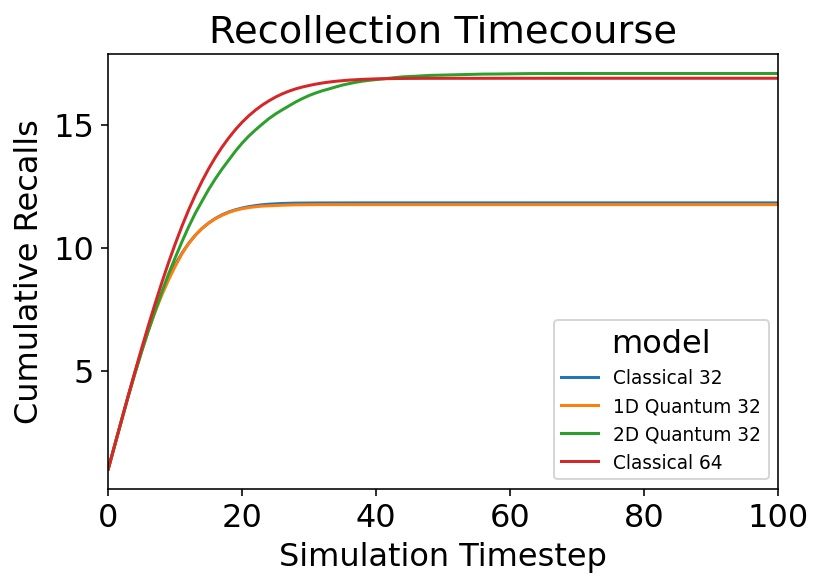

In [105]:
plt.plot(historyC1.cumsum(axis=1).mean(axis=0))
plt.plot(historyQ1.cumsum(axis=1).mean(axis=0))
plt.plot(historyQ2.cumsum(axis=1).mean(axis=0))
plt.plot(historyC2.cumsum(axis=1).mean(axis=0))
plt.ylabel('Cumulative Recalls')
plt.xlabel('Simulation Timestep')
plt.title('Recollection Timecourse')
plt.legend(['Classical 32','1D Quantum 32', '2D Quantum 32', 'Classical 64'], title="model", fontsize='xx-small')
plt.xlim((0,100))

The shapes of the experimental timecourse appears similar across models, in that I'm note sure if there's any sort of behavioral experiment that can distinguish these timecourse curves. 

### Conclusions:

Unfortunately it seems impossible to distinguish the quantum and classical models, in practice, when the models are tuned to produce a similar number of recalled items.

## Overall Conclusions

In this project, I sucessfully constructed a model of quantum free recall.

It was found that, depending on the parameter values of the model, recall could be either far worse or far better than the classical model. The relationship between performance, the overall dimensionality, and the dimensionality of the conceptual subspace was found to be quite complex:

- When the subspace dimensionality is fixed, performance increases to an asymptote as the overall dimensionality increases.
- When the conceptual subspaces are 1D, model performance is the same as classical by all metrics investigated.
- When the overall dimensionality is fixed, and the subspace dimensionality is increased, the recall rate first increases above the classical baseline and then falls below it.
- There appears to be a scaling law, where the optimal number of subspace dimensions scales proportionally to a power of the overall dimensionality.
- A model with high enough overall dimensionality and the right conceptual dimensionality can acheive essentially perfect recall.

Regarding the primary question, "can quantum cognition help with recall", the answer is yes: the path-dependent effects of the quantum model are sufficient to allow the agent to explore a higher portion of the conceptual space.

The primary issues with the quantum model is of biological plausibility.  Based on the results of the these experiments, I feel that is is unlikely for a biological agent to use a quantum model of recall, based on the human experiment data from Naim et al.

- Even a low dimensionality for the conceptual subspaces (2D) leads to a recall rate way higher than the classical model for the same number of concepts in memory. If this value (number of concepts) is estimated using a recognition task like in Naim et al., this effect would be noticeable.
- The only ways to explain the experimental data using this quantum model would be... either the conceptual subspaces are usually 1D (which I believe reduces to the classical model), or the number of items available to the recall algorithm is actually much smaller than the number of recognizeable concepts (Naim et al. assumed they were the same).
- It seems extremely difficult to distinguish the classical and quantum when the number of recallable items in the classical model is allowed to scale up to produce a similar average number of recalled items.
- If an agent could use randomly-produced 2D conceptual subspaces during recall to improve performance, why wouldn't they? There are classical methods that increase recall rate (like chunking) but it makes sense that chunking can be difficult to apply constantly all the time (because it requires special structure in the similarity matrix).

So, I am forced to conclude that the classical model fits the available behavioral data best.  Perhaps other, classical forms of path-dependency (like patterns in the graph weight matrix) could explain recall better when people are able to exceed the "baseline" prediction of the random graph model.